In [ ]:
%load_ext autoreload
%autoreload 2
%cd ..
%pwd

import torch

# device = torch.device("cpu")

device = torch.device("cuda")

In [2]:
import numpy as np
import scipy.stats

#https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n - 1)
    return m, m - h, m + h

def set_dict_entry(dictionary, keys, value):
    for key in keys[:-1]:
        dictionary = dictionary.setdefault(key, {})
    dictionary[keys[-1]] = value

def dict_iterator(dictionary, keys=None):
    if keys is None:
        keys = []
    for key, value in dictionary.items():
        new_keys = keys + [key]
        if isinstance(value, dict):
            for pair in dict_iterator(value, keys=new_keys):
                yield pair
        else:
            yield [new_keys, value]

def get_CI(dictionary):
    to_return = {}
    for val in dict_iterator(dictionary):
        utilities = val[1]
        set_dict_entry(to_return, val[0], mean_confidence_interval(utilities))
    return to_return

In [3]:
from PolyRelu import real_relu, generate_coeffs, PolynomialEvaluator

coeffs = generate_coeffs(real_relu, degree=4, file_prefix="./poly_coefs", rng=5., quantized_coef=False)
print(coeffs)
evaluator = PolynomialEvaluator(coeffs)


[ 2.93262012e-01  5.00000000e-01  1.63898929e-01 -1.51731997e-16
 -3.27144880e-03]


{0: deque([9.568533, 11.392935, 22.30646, 411434.62], maxlen=4), 1: deque([8.869667, 13.535114, 46.35766, 71424.12], maxlen=4), 2: deque([8.1216545, 21.97718, 823.79596, 7.249066e+23], maxlen=4)}
0 [9.568533  8.869667  8.1216545]
1 [11.392935 13.535114 21.97718 ]


/tmp/ipykernel_413405/2924924401.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


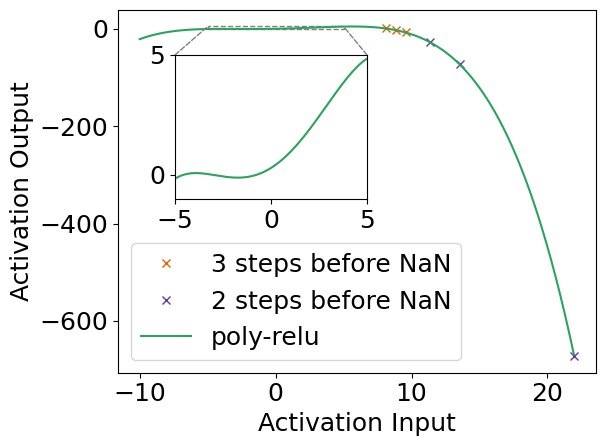

In [58]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch, Rectangle
import pickle

markers = ["o", 'x', 's', 'D', 'p', 'v', '*']
colors = ["#e66101", "#5e3c99", "#fdb863", "#b2abd2", "#2ca25f"]

with open('./experiments/figure_2/l_infinities.pkl', 'rb') as f:
    l_infinities = pickle.load(f)
with open('./experiments/figure_2/maxlen.pkl', 'rb') as f:
    maxlen = pickle.load(f)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
plt.xlabel("Activation Input")
plt.ylabel("Activation Output")
# # Adjust figure size and main plot position
fig.subplots_adjust(left=0.1, bottom=0.1, right=1, top=0.9)
# Create separate Axes object for the magnified part and place it outside the main plot
axins = fig.add_axes([0.3, 0.55, 0.3, 0.3])  # left, bottom, width, height

# we first plot the poly
p_min, p_max = -10., 10
sub_p_min, sub_p_max = -5., 5.
in_sub = []
print(l_infinities)
# we now plot the last values in the buffer
for i in range(0, maxlen-2):
    color = colors[i]
    x = []
    for queue in l_infinities.values():
        x.append(queue.popleft())
    for x_i in x:
        if sub_p_min <= x_i <= sub_p_max:
            in_sub.append((x_i, color))
    x = torch.Tensor(x)
    y = evaluator(x).cpu().detach().numpy()
    x = x.cpu().detach().numpy()
    if np.max(x) > p_max:
        p_max = np.max(x)
    if np.min(x) < p_min:
        p_min = np.min(x)

    print(i, x)
    ax.plot(x, y, label=f"{maxlen-i-1} steps before NaN", marker="x", linestyle="", color=color)

step = (p_max - p_min)/1000
x = torch.arange(start=p_min, end=p_max, step=step)
y = evaluator(x).cpu().detach().numpy()
x = x.cpu().detach().numpy()
ax.plot(x, y, label="poly-relu", color=colors[-1])

ax.legend()
x = torch.arange(start=sub_p_min, end=sub_p_max, step=step)
y = evaluator(x).cpu().detach().numpy()
x = x.cpu().detach().numpy()
axins.plot(x, y, color=colors[-1])
for value, color in in_sub:
    x = torch.Tensor(value)
    y = evaluator(x).cpu().detach().numpy()
    x = x.cpu().detach().numpy()
    axins.plot(x, y, color=color)

x1, x2, y1, y2 = -5, 5, -1, 5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='grey', facecolor ='none', linestyle ="--")
ax.add_patch(rect)
# Create lines connecting the magnified part of the main plot to the magnified part’s box
xyA = (x2, y2)
xyB = (x2, y2)
coordsA = "data"
coordsB = "data"
con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA=coordsA, coordsB=coordsB,
                      axesA=axins, axesB=ax, arrowstyle="-", linestyle ="--", color ="grey", linewidth = 1)
axins.add_artist(con)
xyA = (x1, y2)
xyB = (x1, y2)
con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA=coordsA, coordsB=coordsB,
                      axesA=axins, axesB=ax,  arrowstyle="-", linestyle ="--", color ="grey", linewidth = 1)
axins.add_artist(con)
plt.tight_layout()
plt.savefig("figure_2.pdf", bbox_inches='tight')
plt.show()